In [15]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# EDA

In [23]:
telco = pd.read_csv('Data/telco.csv')

In [24]:
telco.tail(2)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
3331,WV,159,415,No,No,0,169.8,114,28.87,197.7,105,16.80,193.7,82,8.72,11.6,4,3.13,1,False
3332,CT,184,510,Yes,No,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


Splitting the data set into numerical and categorical variables.

In [25]:
cat = [
    'State',
    'Area code',
    'International plan',
    'Voice mail plan',
    'Churn']

num = [
    'Account length',
    'Number vmail messages',
    'Total day minutes',
    'Total day calls', 
    'Total day charge', 
    'Total eve minutes',
    'Total eve calls',
    'Total eve charge', 
    'Total night minutes',
    'Total night calls', 
    'Total night charge', 
    'Total intl minutes',
    'Total intl calls', 
    'Total intl charge', 
    'Customer service calls']

In [26]:
def scree_plot(pca_object):
    '''
    Plot a scree plot (Explained variance per principal component in percentage) for a given PCA object.
        * x-axis: different principal components
        * y-ais: explained variance ratios
    '''
    
    ratio = pca_object.explained_variance_ratio_
    
    label_list = []

    for i in range(len(ratio)):
        label_list.append('PC'+str(i+1))
    
    plt.bar(label_list,ratio)

    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')

    plt.title('Scree Plot')
    plt.show()

# Aggregated Numerical Variables

Combining each of the `minutes`, `calls` and `charge` variables to reduce the number of variables.

In [27]:
telco['Total minutes'] = telco['Total day minutes'] + telco['Total eve minutes'] \
+ telco['Total night minutes'] + telco['Total intl minutes']

telco['Total calls'] = telco['Total day calls'] + telco['Total eve calls'] \
+ telco['Total night calls'] + telco['Total intl calls']

telco['Total charge'] = telco['Total day charge'] + telco['Total eve charge'] \
+ telco['Total night charge'] + telco['Total intl charge']

In [28]:
num_agg = [
    'Account length',
    'Number vmail messages',
    'Customer service calls',
    'Total minutes',
    'Total calls',
    'Total charge']

In [29]:
telco[num_agg].tail(5)

,Account length,Number vmail messages,Customer service calls,Total minutes,Total calls,Total charge
3328,114,26,2,551.9,314,50.79
3329,106,29,1,525.1,338,44.06
3330,60,0,3,502.2,370,53.20
3331,159,0,1,572.8,305,57.52
3332,184,0,2,517.6,336,57.53


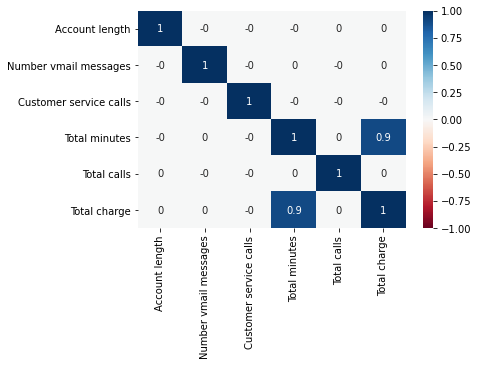

In [30]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

sns.heatmap(telco[num_agg].corr().round(1), vmin=-1,vmax=1,cmap='RdBu',annot=True,ax=ax)

plt.show()

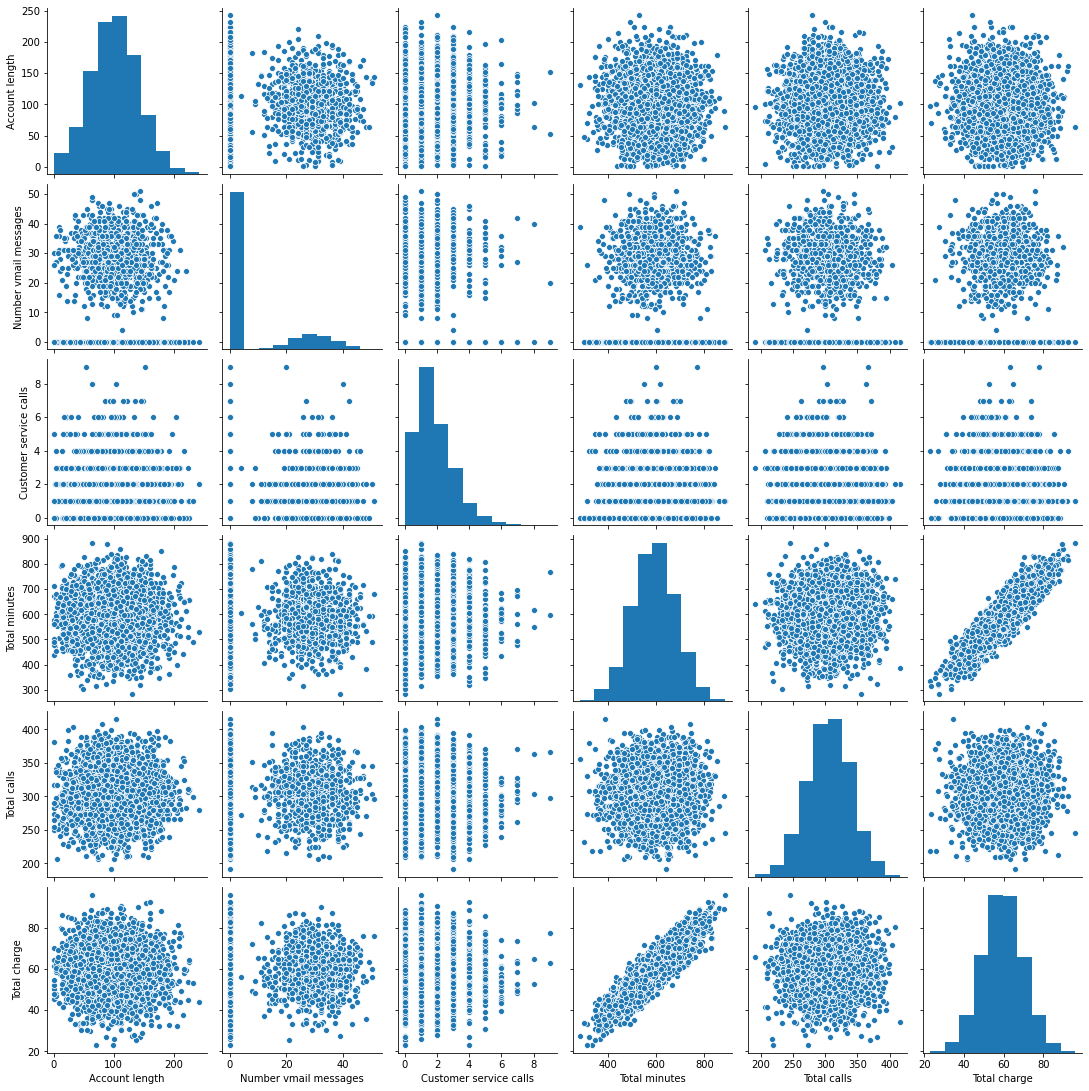

In [31]:
sns.pairplot(telco[num_agg])

## KMeans

In [32]:
kmeans_list = []

cluster_num = range(1,10)

for i in cluster_num:

    kmeans_pipe = Pipeline([('scaler', StandardScaler()),
                                 ('pca', PCA()),
                                 ('kmeans',KMeans(random_state = 42,
                                                  n_clusters = i))])
    
    kmeans_pipe.fit(telco[num_agg])
    
    kmeans_list.append(kmeans_pipe)

In [33]:
kmeans_list[0][-2]

PCA()

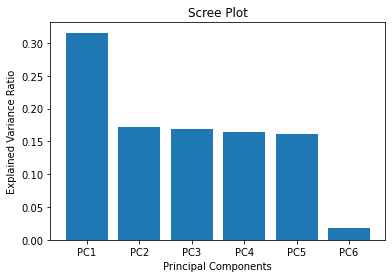

In [34]:
scree_plot(kmeans_list[1][-2])

In [35]:
kmeans_list[1][-2].explained_variance_ratio_[:2].sum()

0.48780524501223876

The first two PCAs account for about 50% of the variance.

In [36]:
inertia_list = []

for i in range(len(cluster_num)):
    inertia_list.append(kmeans_list[i][-1].inertia_)

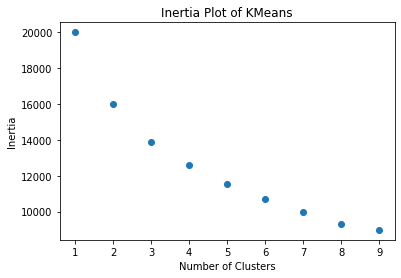

In [37]:
#Plot the inertias

plt.scatter(cluster_num, inertia_list)

plt.ylabel('Inertia')
plt.xlabel('Number of Clusters')

plt.title('Inertia Plot of KMeans')

plt.show()

There seems to be no clear elbow. Maybe the scatterplot of the first two PCAs will offer some more insight.

In [38]:
kmeans_final = Pipeline([('scaler', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('kmeans',KMeans(random_state = 42,
                                     n_clusters = 4))])
kmeans_final.fit(telco[num_agg])

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

In [39]:
kmeans_final[-1].labels_

array([2, 0, 0, ..., 3, 0, 0], dtype=int32)

In [40]:
silhouette_score(telco[num_agg], kmeans_final[-1].labels_, metric='euclidean')

0.18772165223180884

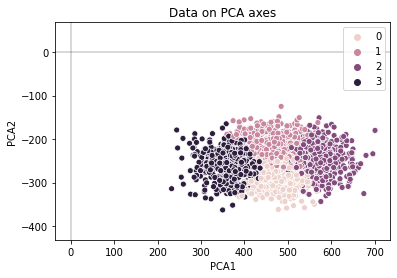

In [41]:
x_num_agg = kmeans_final[-2].transform(telco[num_agg])

sns.scatterplot(x_num_agg[:,0], x_num_agg[:,1], hue=kmeans_final[-1].labels_)

plt.axhline(color='k',alpha=0.2)
plt.axvline(color='k',alpha=0.2)

plt.xlabel('PCA1')
plt.ylabel('PCA2')

plt.title('Data on PCA axes')
plt.axis('equal') #makes the axes equal
plt.show()

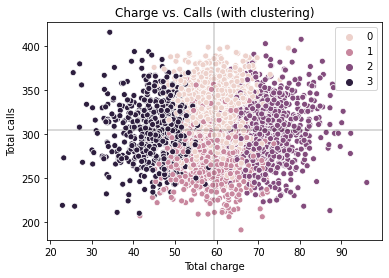

In [42]:
sns.scatterplot('Total charge', 'Total calls',data=telco, hue=kmeans_final[-1].labels_)

plt.axhline(telco['Total calls'].mean(),color='k',alpha=0.2)
plt.axvline(telco['Total charge'].mean(),color='k',alpha=0.2)

plt.title('Charge vs. Calls (with clustering)')
#plt.axis('equal') #makes the axes equal
plt.show()

It turns out, that the scatterplot `Total charge` and `Total calls` closely resembles the PCA scatterplot. We will choose 4 Clusters to account for the four different sectors of the scatterplot.

## DBSCAN

In [43]:
combo = []

for epsi in np.arange(0.0,0.7,0.05):
    for min_sample in range(3,9):

        try:
            #set pipeline
            dbscan_pipe = Pipeline(steps = [('scaler', StandardScaler()),
                                            ('pca',PCA(n_components=2)),
                                                ('dbscan',DBSCAN(eps=0.4, min_samples=min_sample,
                                                                 n_jobs=-1))])

            dbscan_pipe.fit(telco[num_agg])

            labels = dbscan_pipe[-1].labels_
            
            sil = silhouette_score(telco[num_agg][labels != -1], labels[labels != -1], metric='euclidean')

        except:
            sil = np.nan
            
        combo.append([epsi,min_sample,sil])

In [44]:
combo_df = pd.DataFrame(combo,columns=['eps','min_sample','silhouette_score'])
combo_df.sort_values(by='silhouette_score',ascending=False).head(30)

,eps,min_sample,silhouette_score
80,0.65,5,0.418452
20,0.15,5,0.418452
56,0.45,5,0.418452
50,0.40,5,0.418452
44,0.35,5,0.418452
38,0.30,5,0.418452
68,0.55,5,0.418452
32,0.25,5,0.418452
26,0.20,5,0.418452
62,0.50,5,0.418452


In [45]:
dbscan_final = Pipeline(steps = [('scaler', StandardScaler()),
                                 ('pca',PCA(n_components=2)),
                                 ('dbscan',DBSCAN(eps=0.2, min_samples=5,
                                                                 n_jobs=-1))])
dbscan_final.fit(telco[num_agg])

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('dbscan', DBSCAN(eps=0.2, n_jobs=-1))])

In [46]:
labels = dbscan_final[-1].labels_

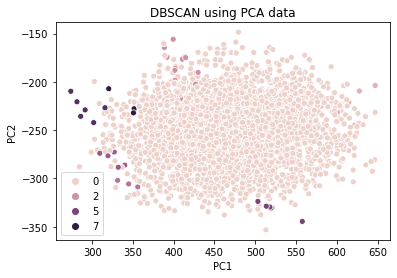

In [47]:
x_num_agg = dbscan_final[-2].transform(telco[num_agg])

#Plot the data on the PCA transformed axes
sns.scatterplot(x_num_agg[labels != -1, 0],
                x_num_agg[labels != -1, 1],
                hue = labels[labels != -1])

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.title('DBSCAN using PCA data')
plt.show()

DBSCAN does not offer better results than KMeans.

# Clusters

In [48]:
kmeans_final = Pipeline([('scaler', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('kmeans',KMeans(random_state = 42,
                                     n_clusters = 4))])
kmeans_final.fit(telco[num_agg])

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

In [49]:
telco['label'] = kmeans_final[-1].labels_

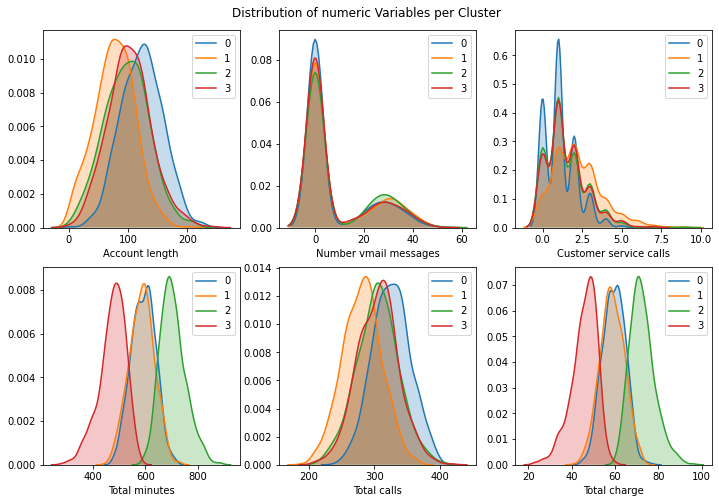

In [50]:
fig, axs = plt.subplots(2,3, figsize=(12,8))

for column, ax in zip(num_agg, axs.flatten()):
     for each in range(len(telco['label'].unique())):
        sns.kdeplot(telco[column][telco['label']==each],ax=ax,label=each,shade=True)
        ax.set_xlabel(column)

plt.suptitle('Distribution of numeric Variables per Cluster', y=0.92)
plt.show()

Clusters vary in:

* Account length
* Customer service calls
* Total minutes
* Total calls
* Total charge


In [51]:
telco['label'].value_counts()

0    994
1    862
2    768
3    709
Name: label, dtype: int64

In [52]:
for each in range(len(telco['label'].unique())):    
    print(f'### Group {each} means:')
    
    for var in num_agg:
        print(f'{var}: {telco[telco["label"]==each][var].mean():.1f}, ({telco[var].mean():.1f} +- {telco[var].std():.1f})')
    
    churn_rate = telco[telco["label"]==each]["Churn"].sum()/len(telco[telco["label"]==each]["Churn"])
    total_churn = telco["Churn"].sum()/len(telco["Churn"])
    
    print(f'Churn rate: {churn_rate*100:.2f}% ({total_churn*100:.2f}%)')
    print('')

### Group 0 means:
Account length: 123.1, (101.1 +- 39.8)
Number vmail messages: 7.4, (8.1 +- 13.7)
Customer service calls: 1.1, (1.6 +- 1.3)
Total minutes: 592.7, (591.9 +- 90.0)
Total calls: 325.8, (305.1 +- 34.4)
Total charge: 59.6, (59.4 +- 10.5)
Churn rate: 6.64% (14.49%)

### Group 1 means:
Account length: 77.5, (101.1 +- 39.8)
Number vmail messages: 8.4, (8.1 +- 13.7)
Customer service calls: 2.2, (1.6 +- 1.3)
Total minutes: 586.4, (591.9 +- 90.0)
Total calls: 281.4, (305.1 +- 34.4)
Total charge: 58.8, (59.4 +- 10.5)
Churn rate: 11.72% (14.49%)

### Group 2 means:
Account length: 97.7, (101.1 +- 39.8)
Number vmail messages: 9.0, (8.1 +- 13.7)
Customer service calls: 1.5, (1.6 +- 1.3)
Total minutes: 704.5, (591.9 +- 90.0)
Total calls: 305.0, (305.1 +- 34.4)
Total charge: 72.6, (59.4 +- 10.5)
Churn rate: 30.86% (14.49%)

### Group 3 means:
Account length: 102.5, (101.1 +- 39.8)
Number vmail messages: 7.7, (8.1 +- 13.7)
Customer service calls: 1.5, (1.6 +- 1.3)
Total minutes: 475.4,

# 4 Groups

### 0 (Happy, long time customers):

Account length: 123.1, (101.1 +- 39.8)

Customer service calls: 1.1, (1.6 +- 1.3)

Total calls: 325.8, (305.1 +- 34.4)

Churn rate: **6.64%** (14.49%)

### 1 (short term, unhappy customers):
Account length: 77.5, (101.1 +- 39.8)

Customer service calls: 2.2, (1.6 +- 1.3)

Total calls: 281.4, (305.1 +- 34.4)

Churn rate: **11.72%** (14.49%)

### 2 (Talkers):

Total minutes: 704.5, (591.9 +- 90.0)

Total charge: 72.6, (59.4 +- 10.5)

Churn rate: **30.86%** (14.49%)

### 3 (Emergency only):

Total minutes: 475.4, (591.9 +- 90.0)

Total charge: 45.9, (59.4 +- 10.5)

Churn rate: **11.14%** (14.49%)

In [53]:
for each in range(len(telco['label'].unique())):    
    print(f'### Group {each}:')
        
    print(f'Group size: {telco["label"].value_counts()[each] / telco.shape[0]*100:.1f}%')
    
    sales_rate = telco['Total charge'][telco['label']==each].sum() / telco['Total charge'].sum()
    
    print(f"Sales percentage: {sales_rate*100:.1f}%")

    churn_rate = telco[telco["label"]==each]["Churn"].sum()/len(telco[telco["label"]==each]["Churn"])
    total_churn = telco["Churn"].sum()/len(telco["Churn"])
    
    print(f"Sales lost: {sales_rate*churn_rate*100:.1f}%")
    
    #print(f'Churn rate: {churn_rate*100:.2f}% ({total_churn*100:.2f}%)')
    print('')

### Group 0:
Group size: 29.8%
Sales percentage: 29.9%
Sales lost: 2.0%

### Group 1:
Group size: 25.9%
Sales percentage: 25.6%
Sales lost: 3.0%

### Group 2:
Group size: 23.0%
Sales percentage: 28.1%
Sales lost: 8.7%

### Group 3:
Group size: 21.3%
Sales percentage: 16.4%
Sales lost: 1.8%



### Group 0:
Group size: 29.8%

Sales percentage: 29.9%

Sales lost: 2.0%

### Group 1:

Group size: 25.9%

Sales percentage: 25.6%

Sales lost: 3.0%

### Group 2:

Group size: 23.0%

Sales percentage: 28.1%

Sales lost: 8.7%

### Group 3:

Group size: 21.3%

Sales percentage: 16.4%

Sales lost: 1.8%

# Summary and Suggestions

**Summary**

* Customers can be split up into 4 Clusters
* “Talkers” are the only group with an above average churn rate (30%)
* “Talkers” account for 9% of lost charges

**Suggestions**

* Focus on “Talkers”
* Incentives for extensive users
